## Code to train DQN with APSF representations

In [13]:
import sys,os
sys.path.append('../')
from deep_rl import *
import matplotlib.pyplot as plt
import torch
# torch.multiprocessing.set_start_method('spawn')
from tqdm import trange, tqdm
import random
import numpy as np
select_device(-1)
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
torch.cuda.current_device()

0

In [19]:
def dqn_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: VanillaNet(config.action_dim, FCBody(config.state_dim, hidden_units=(16,)))
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 3e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    run_steps(DQNAgent(config))
#     agent = DQNAgent(config)
#     #run_steps function below
#     config = agent.config
#     agent_name = agent.__class__.__name__
#     t0 = time.time()
#     while True:
#         if config.save_interval and not agent.total_steps % config.save_interval:
#             agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
#         if config.log_interval and not agent.total_steps % config.log_interval:
#             t0 = time.time()
#         if config.eval_interval and not agent.total_steps % config.eval_interval:
#             agent.eval_episodes()
#             pass
#         if config.max_steps and agent.total_steps >= config.max_steps:
#             return agent
#             break
#         agent.step()
#         agent.switch_task()
#     return agent

In [20]:
game = 'FourRoomsMatrix'
agent = dqn_feature(game=game)

starting making env


2021-06-16 22:32:58,849 - root - INFO: steps 0, 65536000.00 steps/s


starting making env


2021-06-16 22:32:59,051 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2021-06-16 22:32:59,380 - root - INFO: steps 1000, 1889.12 steps/s
2021-06-16 22:32:59,709 - root - INFO: steps 2000, 3045.26 steps/s
2021-06-16 22:33:00,024 - root - INFO: steps 3000, 3183.43 steps/s
2021-06-16 22:33:00,370 - root - INFO: steps 4000, 2889.89 steps/s
2021-06-16 22:33:00,691 - root - INFO: steps 5000, 3128.77 steps/s
2021-06-16 22:33:00,848 - root - INFO: steps 5000, episodic_return_test -160.50(24.98)
2021-06-16 22:33:01,181 - root - INFO: steps 6000, 2040.17 steps/s
2021-06-16 22:33:01,501 - root - INFO: steps 7000, 3133.93 steps/s
2021-06-16 22:33:01,822 - root - INFO: steps 8000, 3117.87 steps/s
2021-06-16 22:33:02,141 - root - INFO: steps 9000, 3141.33 steps/s
2021-06-16 22:33:02,451 - root - INFO: steps 10000, 3234.27 steps/s
2021-06-16 22:33:02,631 - root - INFO: steps 10000, episodic_return_test -180.20(18.78)
2021-06-16 22:33:02,941 - root - INFO: steps 11000, 2042.44 steps/s
202

KeyboardInterrupt: 

  File "/home/yiranwang/anaconda3/envs/DPC/lib/python3.7/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/home/yiranwang/anaconda3/envs/DPC/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/yiranwang/anaconda3/envs/DPC/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


In [4]:
# plt.figure(figsize=(18,6))
# plt.plot(np.array(agent.returns)[:,0], np.array(agent.returns)[:,1], '.-')
# plt.xlabel('timesteps'), plt.ylabel('returns')
# plt.title('DQN performance on ' + game), plt.show()

### Learning the state representations using APSF

In [4]:
def avdsr_feature(**kwargs):
    kwargs['tag'] = 'Training avDSR based on DQN agents'
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.002)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), \
                                      hidden_units=(), config=0) #CHECK
    config.replay_fn = lambda: Replay(memory_size=int(3e5), batch_size=10)

    config.random_action_prob = LinearSchedule(1, 1, 1e4) # CHECK
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.max_steps = 1e5
    config.async_actor = False
    
    agent = avDSRAgent(config, config.agents, style='DQN')
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.log_interval and not agent.total_steps % config.log_interval:
            agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
#         import pdb; pdb.set_trace()
        agent.step()
        agent.switch_task()

In [5]:
avdsr = avdsr_feature(game='FourRoomsMatrixNoTerm', agents=[agent], choice=0)

2021-06-16 22:12:36,677 - root - INFO: steps 0, 466033777.78 steps/s


starting making env
starting making env


2021-06-16 22:12:37,572 - root - INFO: steps 1000, 1118.03 steps/s
2021-06-16 22:12:38,303 - root - INFO: steps 2000, 1369.33 steps/s
2021-06-16 22:12:39,078 - root - INFO: steps 3000, 1290.50 steps/s
2021-06-16 22:12:39,808 - root - INFO: steps 4000, 1371.23 steps/s
2021-06-16 22:12:40,538 - root - INFO: steps 5000, 1370.60 steps/s
2021-06-16 22:12:41,267 - root - INFO: steps 6000, 1373.59 steps/s
2021-06-16 22:12:42,006 - root - INFO: steps 7000, 1352.55 steps/s
2021-06-16 22:12:42,762 - root - INFO: steps 8000, 1324.67 steps/s
2021-06-16 22:12:43,504 - root - INFO: steps 9000, 1348.74 steps/s
2021-06-16 22:12:44,233 - root - INFO: steps 10000, 1372.66 steps/s
2021-06-16 22:12:45,062 - root - INFO: steps 11000, 1206.76 steps/s
2021-06-16 22:12:45,756 - root - INFO: steps 12000, 1441.48 steps/s
2021-06-16 22:12:46,590 - root - INFO: steps 13000, 1200.78 steps/s
2021-06-16 22:12:47,294 - root - INFO: steps 14000, 1421.52 steps/s
2021-06-16 22:12:48,121 - root - INFO: steps 15000, 1210.

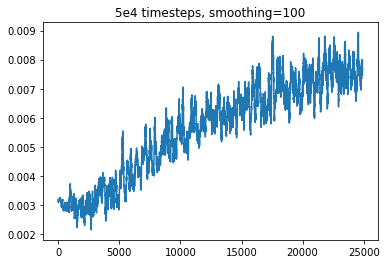

(Text(0.5, 1.0, '5e4 timesteps, smoothing=100'), None)

In [6]:
loss_lr_em3 = avdsr.loss_vec
kernel = 100
plt.plot(convolve(avdsr.loss_vec, kernel))
plt.title('5e4 timesteps, smoothing=' + str(kernel)), plt.show()
# plt.subplot(122), plt.plot(avdsr.retu)

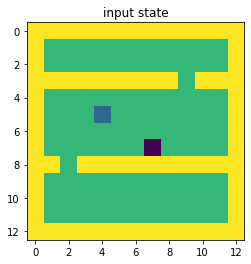

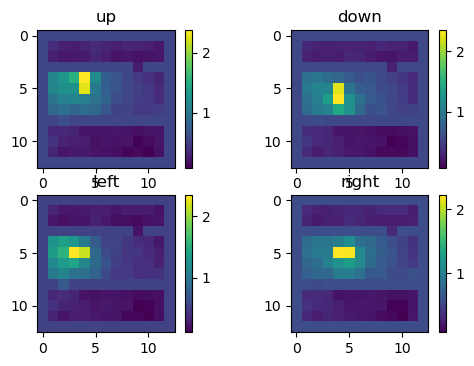

In [9]:
from deep_rl.component.fourrooms import FourRoomsMatrix
env = FourRoomsMatrix()
state = env.reset()
env.step(env.action_space.sample())
env.step(env.action_space.sample())
env.step(env.action_space.sample())
# env.current_cell = (5,5)
state, _, _, _ = env.step(env.action_space.sample())
plt.imshow(env.render()); plt.title('input state'), plt.show()
_, out, _ = avdsr.network(tensor(state).unsqueeze(0))

dirs = {0: 'up', 1: 'down', 2:'left', 3:'right'}

plt.figure(dpi=100)
psi = out.cpu().detach().numpy()
for i in range(4):
    psi_a = psi[0,i,:]
    plt.subplot(2,2,i+1)
    plt.imshow(psi_a.reshape((13,13)))
    plt.title(dirs[i])
    plt.colorbar()

plt.show()

In [9]:
params_count(avdsr.network.psi2q)

169

### Comparing performance:

Likely to improve if DSR is trained for longer with a smaller learning rate

- DQN: 169 -> 676 -> 4
- avDSR: 169 -> 676 -> 4

In [10]:
def dsr_feature_init(ref,**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), config=config.style)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e5), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 3e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    
    agent = DSRAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    if(ref is not None):
        print(agent.network.load_state_dict(ref.network.state_dict(), strict=False))
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
#         import pdb; pdb.set_trace()
        agent.step()
        agent.switch_task()
        
    return agent

In [11]:
def runNAgents(function, runs, store=True, freeze=0, ref=None, style=0):
    r_dqn = []; t_dqn = []
    if(store):
        agents = []
    for i in trange(runs, desc='runs'): 
        agent = function(game='FourRoomsMatrix', freeze=freeze, ref=ref, style=style)
        rewards = np.array(agent.returns)
        t_dqn.append(rewards[:,0])
        r_dqn.append(rewards[:,1])
        if(store):
            agents.append(agent)
            
    if(store):
        return agents, t_dqn, r_dqn
    
    return t_dqn, r_dqn

In [12]:


r_c0 = runNAgents(dsr_feature_init, runs=2, freeze=2, ref=avdsr, style=0)
r_c1 = runNAgents(dsr_feature_init, runs=2, freeze=2, ref=avdsr, style=1)
r_dqn_base_16 = runNAgents(dqn_feature, runs=2)

runs:   0%|          | 0/2 [00:00<?, ?it/s]

starting making env
starting making env
<All keys matched successfully>


2021-06-16 22:17:27,995 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
Process AsyncReplay-4:
Traceback (most recent call last):
  File "/home/yiranwang/anaconda3/envs/DPC/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "../deep_rl/component/replay.py", line 138, in run
    set_up_cache()
  File "../deep_rl/component/replay.py", line 113, in set_up_cache
    batch_data = [tensor(x) for x in batch_data]
  File "../deep_rl/component/replay.py", line 113, in <listcomp>
    batch_data = [tensor(x) for x in batch_data]
  File "../deep_rl/utils/torch_utils.py", line 24, in tensor
    x = torch.tensor(x, device=Config.DEVICE, dtype=torch.float32)
  File "/home/yiranwang/anaconda3/envs/DPC/lib/python3.7/site-packages/torch/cuda/__init__.py", line 164, in _lazy_init
    "Cannot re-initialize CUDA in forked subprocess. " + msg)
RuntimeError: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spa

KeyboardInterrupt: 

In [16]:
def plot_rewards(rewards, plot_seperate=True , clip=50000, title='unnamed'):
    smooth = 5000
    
    colors = ['red', 'blue', 'green', 'm', 'k', 'y', '#999999']
    
    plt.figure(figsize=(16,6), dpi=200)
    if(plot_seperate):
        for k, v in rewards.items():
            for t, r in zip(v[0], v[1]):
                plt.plot(t, r, label=k)
        plt.legend(), plt.show()
        return
    
    for j, (k, v) in enumerate(rewards.items()):
        r_vec = np.zeros((len(v[0]), clip-smooth+1))
        for i, (t, r) in enumerate(zip(v[0], v[1])):
            r_vec[i,:] = convolve(np.interp(np.arange(clip), t, r), smooth)
    
        mean = np.mean(np.array(r_vec), axis=0)
        std = np.std(np.array(r_vec), axis=0)
        plt.plot(mean, label=k, color=colors[j])
        plt.fill_between(np.arange(0, len(mean)), mean+std, mean-std, facecolor=colors[j], alpha=0.3)
    
    plt.xlabel('timesteps'), plt.ylabel('episodic returns')
    plt.title(title)
    plt.legend(loc='lower right'), plt.show()

In [ ]:
rewards_dict = {'DQN (h=(16,))': r_dqn_base_16[1:],
                'APSF($\pi_{\epsilon=1}$) - 169 parameters': r_c0[1:],
                'APSF($\pi_{\epsilon=1}$) - 2708 parameters': r_c1[1:],
               }

plot_rewards(rewards_dict, plot_seperate=False, title='Policy-general SFs: 2 runs on 3rooms(h) env')